In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sdv.tabular import CopulaGAN
from sdv.evaluation import evaluate
from sdv.constraints import UniqueCombinations, GreaterThan


import os, glob

In [37]:
def plot_corr(data, figsize=(15,15)):
    '''
    Plot correlation 
    Args:
    - data: pd dataframe
    '''
    corr = data.corr()
    sns.set(font_scale=1.2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corr, mask=mask, square=True, cmap='RdBu_r', center=0, 
                         vmin= -1, vmax=1,
                         annot=True,
                        annot_kws={'fontsize':8})

In [38]:
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)

In [39]:
data.index = data.index.str.rstrip('-12345')

In [40]:
mean_df = data.groupby('ID').mean()
mean_df.dropna(how='any', inplace=True)
mean_df['type_cw'] = mean_df.index.astype('str')
mean_df.drop(['%C_IF_2.25MHz', '%C_IF_3.5MHz', '%C_BS'], axis=1, inplace=True)

In [41]:
mean_df

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp,type_cw
ID,,,,,,,,,,,,,,,
304-0,162.000000,0.12000,0.0350,0.08600,-1.54700,0.04900,0.002743,0.46,0.013,2.9,0.4,0.005,1.3,11.10,304-0
304-20,105.780000,0.49600,0.1770,0.23900,-1.32200,0.06300,0.002093,0.69,0.014,2.0,0.6,0.006,1.1,9.80,304-20
304-40,100.700000,1.35000,0.3770,0.37700,-1.21600,0.05300,0.001941,0.72,0.022,3.0,0.6,0.012,1.9,8.90,304-40
304-60,91.320000,1.37100,0.5310,0.90900,-1.24900,0.05200,0.002567,0.91,0.010,1.1,0.8,0.015,1.7,11.40,304-60
304-80,73.775000,3.96600,1.3495,2.47650,-0.97600,0.06425,0.002420,0.89,0.024,2.7,0.9,0.021,2.4,12.20,304-80
316-0,111.240000,0.03900,0.0140,0.01700,-1.50600,0.04600,0.002433,0.46,0.030,6.5,0.4,0.010,2.4,10.72,316-0
316-20,69.960000,0.03600,0.0100,0.01600,-1.57300,0.04500,0.002785,0.61,0.026,4.3,0.6,0.004,0.7,13.97,316-20
316-40,68.220000,0.04400,0.0160,0.01700,-1.64000,0.04400,0.002494,0.71,0.006,0.8,0.7,0.005,0.8,7.03,316-40
316-60,69.000000,0.04925,0.0165,0.03275,-1.67375,0.04500,0.002292,0.89,0.014,1.6,1.2,0.013,1.0,4.61,316-60


In [42]:
mean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, 304-0 to A286-80
Data columns (total 15 columns):
KJIC               19 non-null float64
MS_Avg             19 non-null float64
MS_neg_error       19 non-null float64
MS_pos_error       19 non-null float64
TEP_average        19 non-null float64
TEP_error          19 non-null float64
Beta_avg           19 non-null float64
IF_amp_2.25MHz     19 non-null float64
SE_IF_2.25MHz      19 non-null float64
SE_%_IF_2.25MHz    19 non-null float64
IF_amp_3.5MHz      19 non-null float64
SE_IF_3.5MHz       19 non-null float64
SE_%_IF_3.5MHz     19 non-null float64
BS_amp             19 non-null float64
type_cw            19 non-null object
dtypes: float64(14), object(1)
memory usage: 2.4+ KB


# CopulaGAN

The sdv.tabular.CopulaGAN model is a variation of the CTGAN Model which takes advantage of the CDF based transformation that the GaussianCopulas apply to make the underlying CTGAN model task of learning the data easier.

# Model the data

## adding constraint - just ignored for now

Do not work either give an error at sampling for reject_sampling in GreaterThan or error at fit for UniqueCombinations

Maybe to test remove zero data to avoid errors:
`mean_df=mean_df[(mean_df != 0).all(1)]`

In [43]:
TEP_constraint = GreaterThan(low='TEP_error', high='TEP_average', handling_strategy='all')

PC225_constraint = GreaterThan(low='SE_%_IF_2.25MHz', high='IF_amp_2.25MHz', handling_strategy='all')

PC35_constraint = GreaterThan(low='SE_%_IF_3.5MHz', high='IF_amp_3.5MHz', handling_strategy='all')


constraints = [TEP_constraint, PC225_constraint,  PC35_constraint]

## tuning distribution and fitting model

In [46]:
model = CopulaGAN(
    epochs=5000,
    #constraints=constraints,
    field_distributions={
        'KJIC':'gaussian_kde',
    }
)

In [47]:
model.fit(mean_df)

In [48]:
model.get_distributions()

{'KJIC': 'copulas.univariate.gaussian_kde.GaussianKDE',
 'MS_Avg': 'copulas.univariate.beta.BetaUnivariate',
 'MS_neg_error': 'copulas.univariate.gamma.GammaUnivariate',
 'MS_pos_error': 'copulas.univariate.gamma.GammaUnivariate',
 'TEP_average': 'copulas.univariate.student_t.StudentTUnivariate',
 'TEP_error': 'copulas.univariate.log_laplace.LogLaplace',
 'Beta_avg': 'copulas.univariate.gaussian.GaussianUnivariate',
 'IF_amp_2.25MHz': 'copulas.univariate.student_t.StudentTUnivariate',
 'SE_IF_2.25MHz': 'copulas.univariate.uniform.UniformUnivariate',
 'SE_%_IF_2.25MHz': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'IF_amp_3.5MHz': 'copulas.univariate.log_laplace.LogLaplace',
 'SE_IF_3.5MHz': 'copulas.univariate.gamma.GammaUnivariate',
 'SE_%_IF_3.5MHz': 'copulas.univariate.log_laplace.LogLaplace',
 'BS_amp': 'copulas.univariate.student_t.StudentTUnivariate'}

# Generate synthetic data

In [49]:
samples = model.sample(1000)

In [50]:
samples.head()

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp,type_cw
0,104.509264,1.065855,0.327941,0.389267,-1.381644,0.053704,0.001991,0.834178,0.020991,3.214580,0.572778,0.014074,1.923546,7.903716,304-40
1,121.243211,0.527884,0.072630,0.192897,-1.338246,0.049170,0.002014,0.790009,0.017016,3.217831,0.514249,0.013415,2.044493,9.467436,304-40
2,79.715363,0.043292,0.034634,0.024251,-1.726655,0.044679,0.002272,0.905257,0.014341,1.586630,0.889712,0.017395,0.941155,4.245708,316-60
3,64.051840,0.019697,0.028520,0.011775,-1.617859,0.045108,0.002848,0.743794,0.024531,4.418423,0.568634,0.004623,0.690947,13.192833,316-20
4,73.157311,1.674169,0.706512,0.975727,-1.163593,0.050287,0.002355,0.936776,0.030000,4.412032,0.734233,0.014353,2.847758,10.842438,347-60


In [51]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
KJIC               1000 non-null float64
MS_Avg             1000 non-null float64
MS_neg_error       1000 non-null float64
MS_pos_error       1000 non-null float64
TEP_average        1000 non-null float64
TEP_error          1000 non-null float64
Beta_avg           1000 non-null float64
IF_amp_2.25MHz     1000 non-null float64
SE_IF_2.25MHz      1000 non-null float64
SE_%_IF_2.25MHz    1000 non-null float64
IF_amp_3.5MHz      1000 non-null float64
SE_IF_3.5MHz       1000 non-null float64
SE_%_IF_3.5MHz     1000 non-null float64
BS_amp             1000 non-null float64
type_cw            1000 non-null object
dtypes: float64(14), object(1)
memory usage: 117.3+ KB


### Evaluate

The output of this function call will be a number between 0 and 1 that will indicate us how similar the two tables are, being 0 the worst and 1 the best possible score.

The evaluate function applies a collection of pre-configured metric functions and returns the average of the scores that the data obtained on each one of them. To explore the metrics in more detail, you can pass and additional argument aggregate=False.


- cstest: This metric compares the distributions of all the categorical columns of the table by using a Chi-squared test and returns the average of the p-values obtained across all the columns. If the tables that you are evaluating do not contain any categorical columns the result will be nan.

- kstest: This metric compares the distributions of all the numerical columns of the table with a two-sample Kolmogorov–Smirnov test using the empirical CDF and returns the average of the p-values obtained across all the columns. If the tables that you are evaluating do not contain any numerical columns the result will be nan.

- logistic_detection: This metric tries to use a Logistic Regression classifier to detect whether each row is real or synthetic and then evaluates its performance using an Area under the ROC curve metric. The returned score is 1 minus the ROC AUC score obtained by the classifier.

- svc_detection: This metric tries to use an Support Vector Classifier to detect whether each row is real or synthetic and then evaluates its performance using an Area under the ROC curve metric. The returned score is 1 minus the ROC AUC score obtained by the classifier.


In [52]:
evaluate(samples, mean_df)

0.7383656043962047

In [53]:
evaluate(samples, mean_df, aggregate = False)

{'cstest': 1.0,
 'kstest': 0.7341451533573744,
 'logistic_detection': 0.6531636426846007,
 'svc_detection': 0.5699025943536922}

In [54]:
mean_df.describe()

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,96.482982,0.982158,0.348000,0.570039,-1.355789,0.051447,0.002364,0.782632,0.017684,2.642105,0.826316,0.016211,2.110526,9.335263
std,43.537916,1.720298,0.628664,0.954536,0.228090,0.007534,0.000273,0.322074,0.007550,1.526913,0.495359,0.017012,2.223085,3.326492
min,47.166667,0.009250,0.002000,0.002000,-1.673750,0.044000,0.001770,0.200000,0.006000,0.800000,0.200000,0.002000,0.500000,3.340000
25%,69.480000,0.029000,0.007500,0.013500,-1.526500,0.045125,0.002212,0.650000,0.012500,1.600000,0.600000,0.005500,1.000000,7.440000
50%,77.800000,0.120000,0.035000,0.086000,-1.364000,0.049000,0.002420,0.790000,0.018000,2.200000,0.700000,0.012000,1.500000,9.800000
75%,108.510000,1.180750,0.333000,0.524750,-1.247000,0.055000,0.002556,0.890000,0.023500,3.350000,0.950000,0.016500,2.100000,11.250000
max,198.500000,6.391000,2.338000,2.815000,-0.822000,0.069000,0.002785,1.500000,0.030000,6.500000,2.100000,0.063000,9.500000,15.440000


In [55]:
samples.describe()

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,96.149168,0.732369,0.273468,0.480762,-1.399104,0.050716,0.002361,0.834893,0.017608,2.776661,0.872915,0.019108,2.035771,9.296949
std,42.733895,1.618695,0.505970,0.827377,0.243173,0.008902,0.000262,0.305476,0.007699,1.524541,0.533581,0.018664,2.075318,3.195901
min,34.713346,0.009250,0.002000,0.002000,-1.848372,0.044000,0.001667,0.107004,0.006000,0.800000,0.097766,0.002000,0.256429,2.093536
25%,66.772419,0.010214,0.002110,0.002482,-1.586756,0.045070,0.002183,0.681250,0.010865,1.576613,0.570941,0.007331,1.018243,7.170755
50%,82.412990,0.044670,0.019630,0.046132,-1.421420,0.047509,0.002376,0.814317,0.018114,2.508386,0.751042,0.014464,1.466868,9.693306
75%,111.162145,0.474456,0.247732,0.465835,-1.263246,0.052652,0.002548,0.957148,0.023528,3.710734,1.015184,0.021439,2.032086,11.398594
max,225.064289,6.391000,2.668106,3.779058,-0.764475,0.113708,0.002936,1.925373,0.030000,6.500000,4.738540,0.102537,17.639665,16.937487


In [63]:
short_mean = samples.loc[:, ['KJIC', 'MS_Avg', 'TEP_average',
        'Beta_avg', 'IF_amp_2.25MHz', 'IF_amp_3.5MHz',
       'BS_amp', 'type_cw']]
short_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
KJIC              1000 non-null float64
MS_Avg            1000 non-null float64
TEP_average       1000 non-null float64
Beta_avg          1000 non-null float64
IF_amp_2.25MHz    1000 non-null float64
IF_amp_3.5MHz     1000 non-null float64
BS_amp            1000 non-null float64
type_cw           1000 non-null object
dtypes: float64(7), object(1)
memory usage: 62.6+ KB


In [64]:
short_mean['Type'] = short_mean.type_cw.str.split('-').str[0].astype('str')

In [65]:
short_mean.sort_values('Type', inplace=True)

In [66]:
samples

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,IF_amp_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,IF_amp_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,BS_amp,type_cw
0,104.509264,1.065855,0.327941,0.389267,-1.381644,0.053704,0.001991,0.834178,0.020991,3.214580,0.572778,0.014074,1.923546,7.903716,304-40
1,121.243211,0.527884,0.072630,0.192897,-1.338246,0.049170,0.002014,0.790009,0.017016,3.217831,0.514249,0.013415,2.044493,9.467436,304-40
2,79.715363,0.043292,0.034634,0.024251,-1.726655,0.044679,0.002272,0.905257,0.014341,1.586630,0.889712,0.017395,0.941155,4.245708,316-60
3,64.051840,0.019697,0.028520,0.011775,-1.617859,0.045108,0.002848,0.743794,0.024531,4.418423,0.568634,0.004623,0.690947,13.192833,316-20
4,73.157311,1.674169,0.706512,0.975727,-1.163593,0.050287,0.002355,0.936776,0.030000,4.412032,0.734233,0.014353,2.847758,10.842438,347-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,103.656045,0.903747,0.293774,0.663192,-1.366847,0.050597,0.001837,0.793925,0.012903,2.922287,0.534626,0.016181,2.236833,8.944160,304-40
996,73.563492,0.235263,0.121622,0.337979,-1.323185,0.051098,0.002270,0.905553,0.006000,0.800004,0.816819,0.015096,2.161126,11.757315,347-40
997,195.852151,0.009489,0.002000,0.002000,-1.315298,0.044993,0.002295,0.188705,0.008758,4.360779,0.305240,0.003606,1.996722,8.618148,A286-0
998,111.619924,0.021303,0.003558,0.016754,-1.478194,0.046051,0.002313,0.475078,0.030000,6.493571,0.547826,0.012609,2.780536,9.722967,316-0


In [67]:
samples.to_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data_up.csv'), index=False)

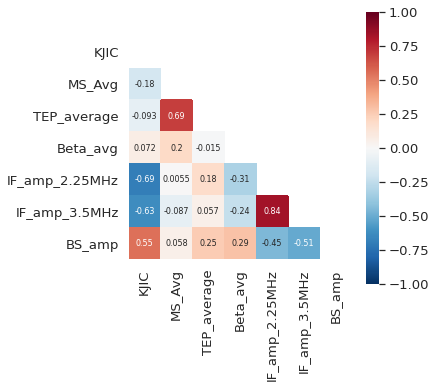

In [68]:
plot_corr(short_mean, figsize=(5,5))

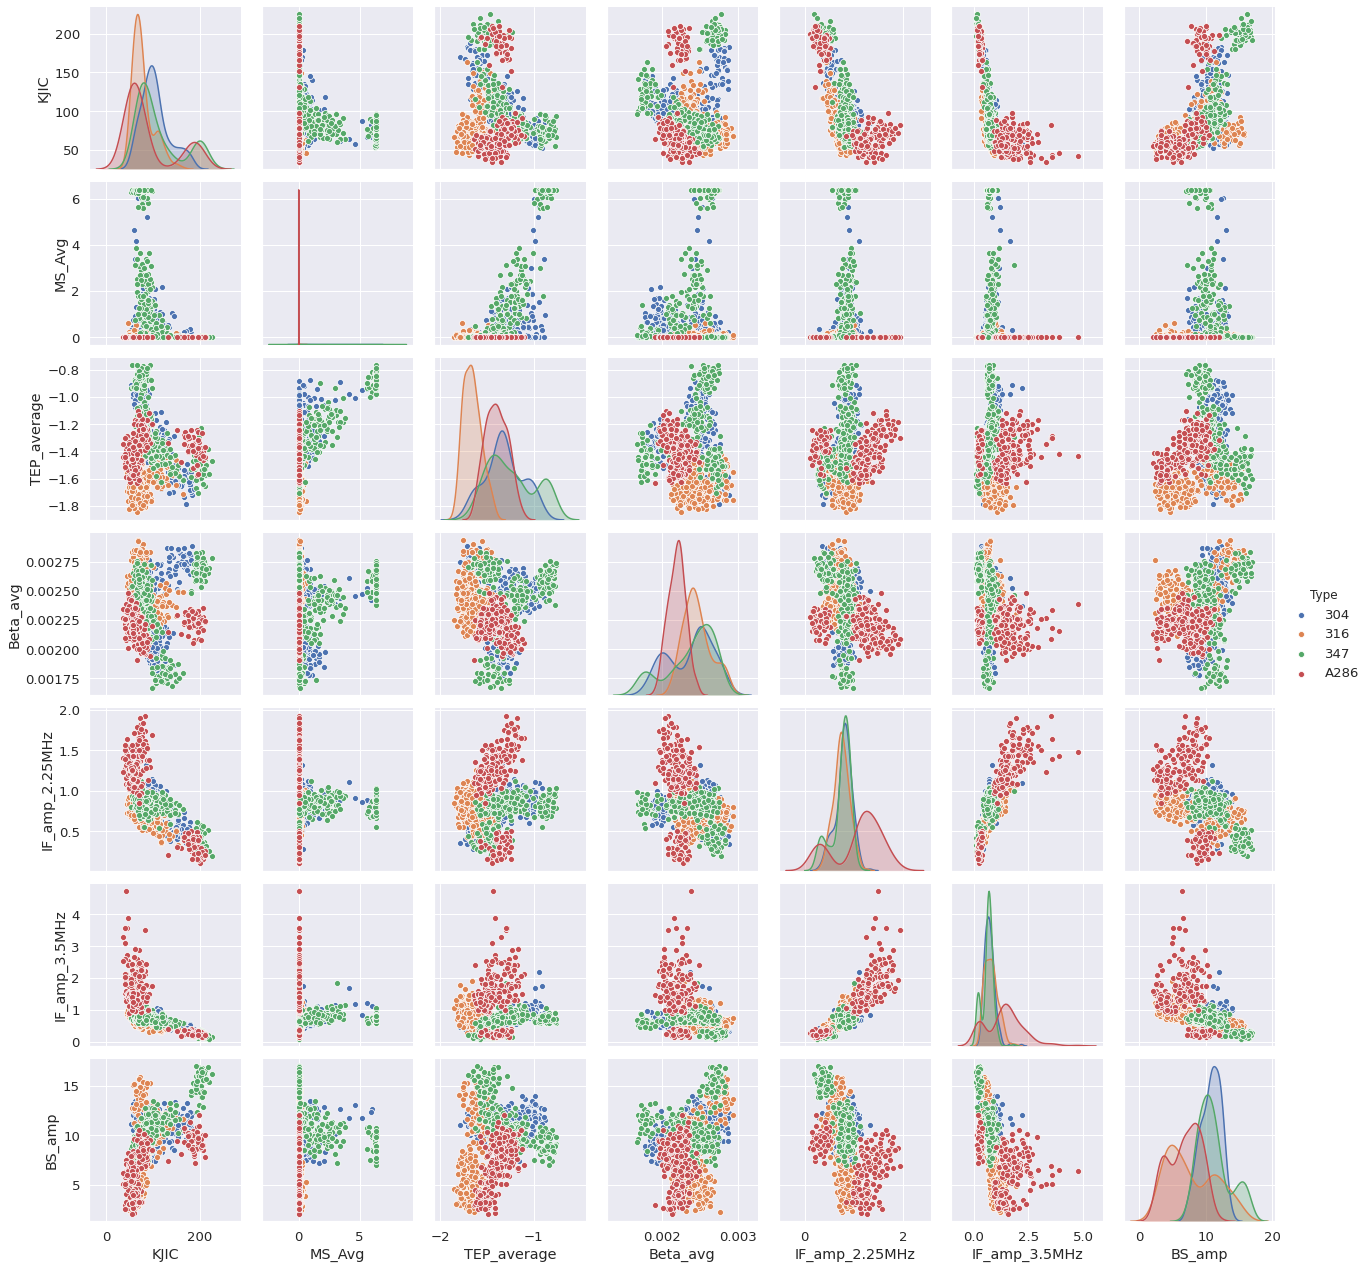

In [69]:
sns.pairplot(short_mean, hue='Type')

# 4. Save and load the synthesizer

To save a trained ctgan synthesizer, use

`model.save('my_model.pkl')`

To restore a saved synthesizer, use

`loaded = CopulaGAN.load('my_model.pkl')`

`new_data = loaded.sample(200)`

In [70]:
model.save('CopulaGAN_up.pkl')